In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
pd.set_option('display.max_colwidth', 1000)

WAR = {'QB': 2.5134, 'WR': 0.701, 'S': 0.6039, 'CB': 0.5172, 'TE': 0.3426, 'IOL': 0.3212, 'OT': 0.2968, 'DE': 0.2783, 'LB': 0.2762, 'RB': 0.2166, 'DT': 0.1868}

In [2]:
data = pd.read_csv(
        'https://raw.githubusercontent.com/leesharpe/nfldata/master/data/draft_picks.csv',
        low_memory=False, usecols=['season', 'team', 'round', 'pick', 'pfr_id', 'pfr_name']
        )

value = pd.read_csv(
        'https://raw.githubusercontent.com/leesharpe/nfldata/master/data/draft_values.csv', 
        usecols=['pick', 'stuart']
        )

trades = pd.read_csv(
        'https://raw.githubusercontent.com/leesharpe/nfldata/master/data/trades.csv'
)

standings = pd.read_csv(
        'https://raw.githubusercontent.com/leesharpe/nfldata/master/data/standings.csv'
)

rosters = pd.read_csv(
        'https://raw.githubusercontent.com/leesharpe/nfldata/master/data/rosters.csv',
        usecols=['season', 'playerid', 'full_name', 'years', 'position', 'av']
)

In [3]:
rosters = rosters[
        (rosters['season'] < 2019) &
        (rosters['years'] < 4)
        ]

rosters = rosters.dropna()

rosters = rosters.replace(to_replace =["RG", "C", "LG", "G"], 
                            value ="IOL")

rosters = rosters.replace(to_replace =["FS", "SS"], 
                            value ="S")

rosters = rosters.replace(to_replace =["RT", "LT", "T"], 
                            value ="OT")

rosters = rosters.replace(to_replace =["LCB", "RCB", "DB"], 
                            value ="CB")

rosters = rosters.replace(to_replace =["MLB", "ROLB", "LOLB", "RILB", "LILB"], 
                            value ="LB")

rosters["position"] = rosters["position"].str.replace("FB", "RB")

rosters = rosters.replace(to_replace =["NT", "RDT", "LDT"], 
                            value ="DT")

rosters = rosters.replace(to_replace =["DL", "EDGE"], 
                            value ="DE")

rosters = rosters.replace(to_replace =["FL", "SE"], 
                            value ="WR")

rosters.head(50)

,season,playerid,full_name,position,years,av
0,2006,LeinMa00,Matt Leinart,QB,0,8.0
4,2006,LutuDe20,Deuce Lutui,IOL,0,5.0
9,2006,BergAd00,Adam Bergen,TE,1,1.0
13,2006,BlacDa20,Darryl Blackstock,LB,1,1.0
14,2006,PaceCa20,Calvin Pace,LB,3,3.0
15,2006,BoldAn00,Anquan Boldin,WR,3,11.0
18,2006,PopeLe00,Leonard Pope,TE,0,1.0
19,2006,BrowMi21,Milford Brown,IOL,3,6.0
22,2006,RollAn20,Antrel Rolle,CB,1,4.0
25,2006,DansKa20,Karlos Dansby,LB,2,5.0


In [4]:
data["team"] = data["team"].str.replace("SD", "LAC")
data["team"] = data["team"].str.replace("OAK", "LV")
data["team"] = data["team"].str.replace("STL", "LA")

draft = data[
        (data['season'] > 2005) &
        (data['season'] < 2019)
        ]

In [5]:
av = (
    rosters.groupby(['playerid', 'full_name']).agg({'av': 'mean', 'position': 'min'})
)

av.sort_values('av', ascending=False, inplace=True)
av.head(50)

,,av,position
playerid,full_name,,
LeonDa00,Darius Leonard,18.000000,LB
MathRa99,Rashean Mathis,18.000000,CB
WillKe98,Kevin Williams,18.000000,DT
WilsRu00,Russell Wilson,17.500000,QB
CassMa00,Matt Cassel,17.000000,QB
JohnLa00,Larry Johnson,17.000000,RB
WattJ.00,J.J. Watt,16.750000,DE
BrigLa99,Lance Briggs,16.000000,LB
WillPa98,Patrick Willis,15.750000,LB


In [6]:
draft_av = pd.merge(draft, av, left_on='pfr_id', right_on='playerid')

In [7]:
draft_av = pd.merge(draft_av, value, left_on='pick', right_on='pick')

In [8]:
draft_av
draft_av['posvalue'] = draft_av['position'].map(WAR)
draft_av['value'] = draft_av['posvalue'] * draft_av['stuart']

draft_av.loc[draft_av['pick'] < 11, 'round'] = 0

In [9]:
draft_av

,season,team,round,pick,pfr_id,pfr_name,av,position,stuart,posvalue,value
0,2006,HOU,0,1,WillMa22,Mario Williams,9.000000,DE,34.6,0.2783,9.62918
1,2007,LV,0,1,RussJa00,JaMarcus Russell,2.000000,QB,34.6,2.5134,86.96364
2,2008,MIA,0,1,LongJa20,Jake Long,11.250000,OT,34.6,0.2968,10.26928
3,2009,DET,0,1,StafMa00,Matthew Stafford,8.500000,QB,34.6,2.5134,86.96364
4,2010,LA,0,1,BradSa00,Sam Bradford,6.750000,QB,34.6,2.5134,86.96364
...,...,...,...,...,...,...,...,...,...,...,...
2356,2015,BAL,5,171,BoylNi00,Nick Boyle,1.666667,TE,1.9,0.3426,0.65094
2357,2016,SEA,5,171,CollAl00,Alex Collins,6.000000,RB,1.9,0.2166,0.41154
2358,2017,BUF,5,171,PeteNa00,Nathan Peterman,1.000000,QB,1.9,2.5134,4.77546
2359,2013,ATL,7,243,IshmKe00,Kemal Ishmael,3.333333,S,0.0,0.6039,0.00000


In [10]:
round_av = (
    draft_av.groupby(['position', 'round']).agg({'av': 'mean'})
).reset_index()

round_av.columns = ['position', 'round', 'ponder']
round_av.sort_values('round', ascending=True, inplace=True)
round_av['WAR'] = round_av['position'].map(WAR)
round_av['value'] = round_av['WAR']*round_av['ponder']

round_av.head(50)

,position,round,ponder,WAR,value
0,CB,0,5.951667,0.5172,3.078202
82,TE,0,4.375000,0.3426,1.498875
74,S,0,6.250000,0.6039,3.774375
24,IOL,0,6.666667,0.3212,2.141333
66,RB,0,9.708333,0.2166,2.102825
90,WR,0,5.990000,0.7010,4.198990
8,DE,0,6.473684,0.2783,1.801626
58,QB,0,8.586806,2.5134,21.582077
45,OT,0,7.377193,0.2968,2.189551
37,LB,0,7.672619,0.2762,2.119177


In [11]:
draft_av = pd.merge(draft_av, round_av, how= 'left', left_on=['round','position'], right_on = ['round','position'])

draft_av['value'] = draft_av['posvalue'] * draft_av['ponder']
draft_av.head(50)

,season,team,round,pick,pfr_id,pfr_name,av,position,stuart,posvalue,value_x,ponder,WAR,value_y,value
0,2006,HOU,0,1,WillMa22,Mario Williams,9.000000,DE,34.6,0.2783,9.62918,6.473684,0.2783,1.801626,1.801626
1,2007,LV,0,1,RussJa00,JaMarcus Russell,2.000000,QB,34.6,2.5134,86.96364,8.586806,2.5134,21.582077,21.582077
2,2008,MIA,0,1,LongJa20,Jake Long,11.250000,OT,34.6,0.2968,10.26928,7.377193,0.2968,2.189551,2.189551
3,2009,DET,0,1,StafMa00,Matthew Stafford,8.500000,QB,34.6,2.5134,86.96364,8.586806,2.5134,21.582077,21.582077
4,2010,LA,0,1,BradSa00,Sam Bradford,6.750000,QB,34.6,2.5134,86.96364,8.586806,2.5134,21.582077,21.582077
5,2011,CAR,0,1,NewtCa00,Cam Newton,15.750000,QB,34.6,2.5134,86.96364,8.586806,2.5134,21.582077,21.582077
6,2012,IND,0,1,LuckAn00,Andrew Luck,12.000000,QB,34.6,2.5134,86.96364,8.586806,2.5134,21.582077,21.582077
7,2013,KC,0,1,FishEr00,Eric Fisher,7.250000,OT,34.6,0.2968,10.26928,7.377193,0.2968,2.189551,2.189551
8,2014,HOU,0,1,ClowJa00,Jadeveon Clowney,7.250000,DE,34.6,0.2783,9.62918,6.473684,0.2783,1.801626,1.801626
9,2015,TB,0,1,WinsJa00,Jameis Winston,11.000000,QB,34.6,2.5134,86.96364,8.586806,2.5134,21.582077,21.582077


In [12]:
value_data = (
    draft_av.groupby(['team']).agg({'value': 'sum', 'stuart': 'sum'})
).reset_index()

value_data['success'] = value_data['value'] / value_data['stuart']

value_data.sort_values('success', ascending=False, inplace=True)

value_data

,team,value,stuart,success
24,NYJ,173.626008,524.3,0.331158
25,PHI,155.830594,480.9,0.324039
20,MIN,156.898231,491.5,0.319223
7,CLE,225.738453,723.2,0.312138
30,TEN,180.680349,579.2,0.311948
9,DEN,173.327684,559.2,0.309957
0,ARI,150.355685,507.3,0.296384
21,NE,133.497866,457.4,0.291862
11,GB,155.210078,536.1,0.289517
2,BAL,136.661693,473.8,0.288438


In [13]:
draft_av = draft_av[
        (draft_av['position'] != "QB") &
        (draft_av['season'] > 2015)
        ]

value_data = (
    draft_av.groupby(['team']).agg({'value': 'sum', 'stuart': 'sum'})
).reset_index()

value_data['success'] = value_data['value'] / value_data['stuart']
a = 1 / value_data['success'].max()
value_data['success'] = value_data['success']*a

value_data.sort_values('value', ascending=False, inplace=True)

value_data

,team,value,stuart,success
7,CLE,33.350159,183.9,0.551955
13,IND,31.752814,158.4,0.610119
28,SF,31.490759,147.7,0.648918
6,CIN,29.598810,115.8,0.777952
30,TEN,28.822627,150.2,0.584051
18,LV,25.799833,117.9,0.666025
26,PIT,25.083824,94.5,0.807884
8,DAL,24.913091,119.8,0.632934
11,GB,24.245895,105.5,0.699476
9,DEN,23.834417,99.7,0.727607


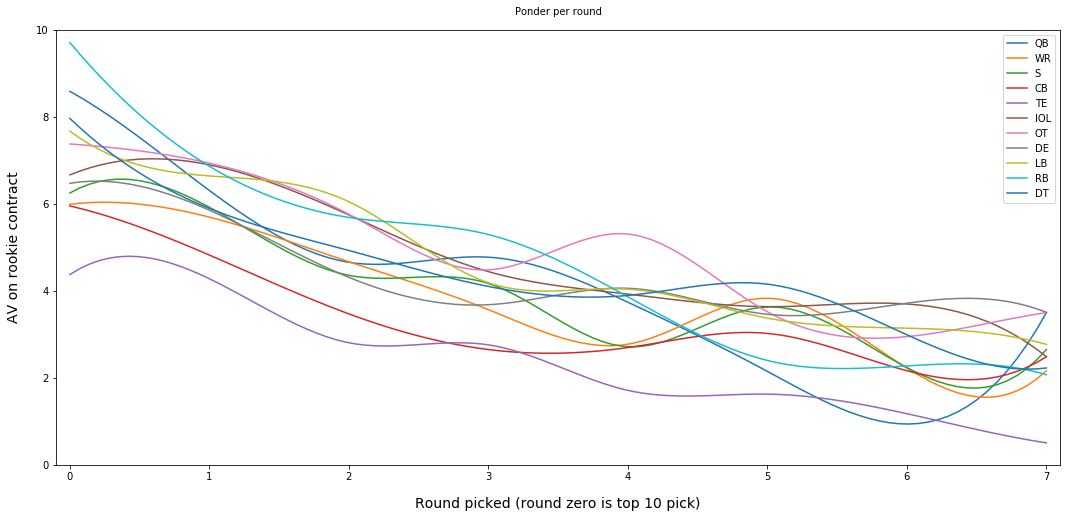

In [14]:
positions = ['QB', 'WR', 'S', 'CB', 'TE', 'IOL', 'OT', 'DE', 'LB', 'RB', 'DT']
fig, ax = plt.subplots(figsize=(18,8))
ax.set_ylim(0, 10)
ax.set_xlim(-0.1, 7.1)

for i in positions:
    plot_round_av = round_av[
            (round_av['position'] == i)
            ].copy()
    x = plot_round_av['round']
    y = plot_round_av['ponder']

    x_smooth = np.linspace(x.min(), x.max(), 100)
    spl = make_interp_spline(x, y, k=3)
    y_smooth = spl(x_smooth)

    plt.plot(x_smooth, y_smooth, label=str(i))

ax.set_title('Ponder per round',fontsize=10,pad=15);
ax.set_xlabel('Round picked (round zero is top 10 pick)', fontsize=14,labelpad=15);
ax.set_ylabel('AV on rookie contract',fontsize=14,labelpad=15);
plt.legend(loc="upper right")
plt.show();

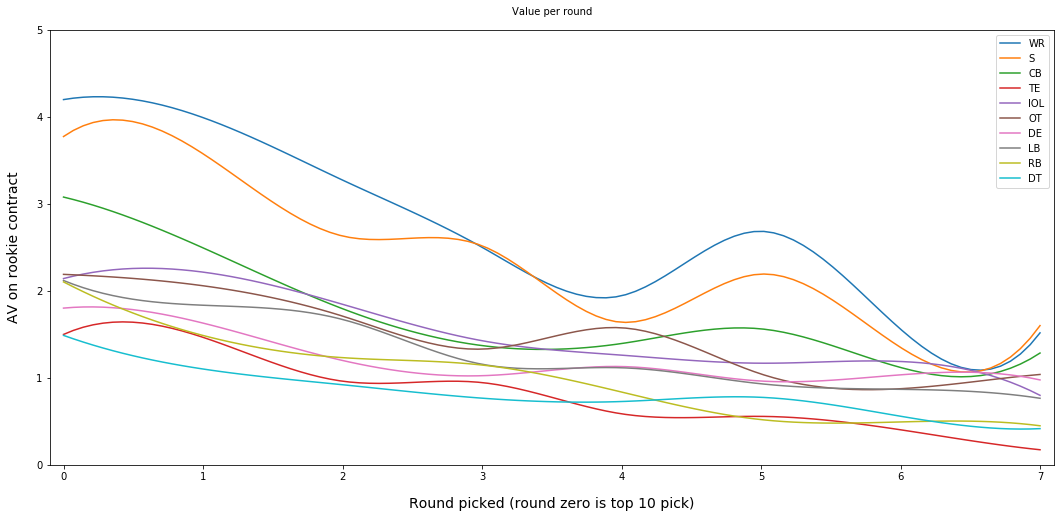

In [19]:
fig, ax = plt.subplots(figsize=(18,8))
ax.set_ylim(0, 5)
ax.set_xlim(-0.1, 7.1)

for i in positions:
    if i == 'QB':
        continue
    plot_round_av = round_av[
            (round_av['position'] == i)
            ].copy()
    x = plot_round_av['round']
    y = plot_round_av['value']

    x_smooth = np.linspace(x.min(), x.max(), 100)
    spl = make_interp_spline(x, y, k=3)
    y_smooth = spl(x_smooth)

    plt.plot(x_smooth, y_smooth, label=str(i))

ax.set_title('Value per round',fontsize=10,pad=15);
ax.set_xlabel('Round picked (round zero is top 10 pick)', fontsize=14,labelpad=15);
ax.set_ylabel('AV on rookie contract',fontsize=14,labelpad=15);
plt.legend(loc="upper right")
plt.show();